<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Introduction To Data Science @ FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling
</div>

This section for bonus, you might need to use some basic Machine Learning algorithms to answer some questions that in cases of regression, and classification. In this scope of this subject, highly recommend you use `scikit-learn` (instead of implement once again these algorithms)

## Import

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

## Data preparation

In [2]:
movie_df = pd.read_csv('./../data/processed.csv')
movie_df

Name  Released year  \
0                      Fast X           2023   
1        Trolls Band Together           2023   
2            Robot Apocalypse           2021   
3     Five Nights at Freddy's           2023   
4                 Oppenheimer           2023   
...                       ...            ...   
4995     Secret in Their Eyes           2015   
4996        The Vatican Tapes           2015   
4997             Song to Song           2017   
4998      Divine Intervention           2023   
4999            Armour of God           1986   

                                                  Genre            Director  \
0                         'Action', 'Crime', 'Thriller'          Dan Mazeau   
1     'Animation', 'Family', 'Music', 'Fantasy', 'Co...          Thomas Dam   
2                           'Science Fiction', 'Action'  Marcus Friedlander   
3                                   'Horror', 'Mystery'          Emma Tammi   
4                                    'Drama', 'History'   Christopher Nolan   
...                                                 ...                 ...   
4995            'Thriller', 'Mystery', 'Drama', 'Crime'           Billy Ray   
4996                               'Thriller', 'Horror'      Mark Neveldine   
4997                        'Romance', 'Drama', 'Music'     Terrence Malick   
4998                                           'Comedy'  Pedro Pablo Ibarra   
4999                    'Adventure', 'Action', 'Comedy'         Jackie Chan   

      Runtime (h)  Score    Status            Language   Budget ($)  \
0            2.37   72.0  Released             English  340000000.0   
1            1.53   72.0  Released             English   95000000.0   
2            1.45   21.0  Released             English          NaN   
3            1.83   78.0  Released             English   20000000.0   
4            3.02   81.0  Released             English  100000000.0   
...           ...    ...       ...                 ...          ...   
4995         1.85   64.0  Released             English   19500000.0   
4996         1.52   53.0  Released             English   13000000.0   
4997         2.15   55.0  Released             English   10000000.0   
4998         1.67   82.0  Released  Spanish; Castilian          NaN   
4999         1.63   70.0  Released           Cantonese   15000000.0   

      Revenue ($)  
0     704709660.0  
1     173800000.0  
2             NaN  
3     286700000.0  
4     951000000.0  
...           ...  
4995   34854990.0  
4996    1784763.0  
4997    1710528.0  
4998          NaN  
4999          NaN  

[5000 rows x 10 columns]

## Feature engineering

In [3]:
df = movie_df[['Genre', 'Runtime (h)', 'Score', 'Budget ($)', 'Revenue ($)']].dropna()

one_hot_df = pd.DataFrame()
def splitGenre(s):
    return s.split(', ')
genre_stack = df['Genre'].apply(splitGenre).agg(pd.Series).stack().agg(pd.Series).stack()
genre_dummy = pd.get_dummies(genre_stack).groupby(level = 0).sum()
genre_dummy.columns = ['Genre_' + col.replace("'", "") for col in genre_dummy.columns]
df = pd.concat([genre_dummy, df], axis = 1)

df = df.drop(['Genre'], axis=1)

profit_percentage = (df['Revenue ($)'] - df['Budget ($)']) / df['Budget ($)']

df

C:\Users\DELL\AppData\Local\Temp\ipykernel_10404\2137955243.py:6: FutureWarning: using <class 'pandas.core.series.Series'> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  genre_stack = df['Genre'].apply(splitGenre).agg(pd.Series).stack().agg(pd.Series).stack()
C:\Users\DELL\AppData\Local\Temp\ipykernel_10404\2137955243.py:6: FutureWarning: using <class 'pandas.core.series.Series'> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  genre_stack = df['Genre'].apply(splitGenre).agg(pd.Series).stack().agg(pd.Series).stack()


Genre_Action  Genre_Adventure  Genre_Animation  Genre_Comedy  \
0                1                0                0             0   
1                0                0                1             1   
3                0                0                0             0   
4                0                0                0             0   
7                1                0                0             1   
...            ...              ...              ...           ...   
4990             1                1                0             0   
4992             0                0                0             0   
4995             0                0                0             0   
4996             0                0                0             0   
4997             0                0                0             0   

      Genre_Crime  Genre_Drama  Genre_Family  Genre_Fantasy  Genre_History  \
0               1            0             0              0              0   
1               0            0             1              1              0   
3               0            0             0              0              0   
4               0            1             0              0              1   
7               0            0             0              0              0   
...           ...          ...           ...            ...            ...   
4990            0            0             0              0              0   
4992            0            1             0              0              0   
4995            1            1             0              0              0   
4996            0            0             0              0              0   
4997            0            1             0              0              0   

      Genre_Horror  ...  Genre_Romance  Genre_Science Fiction  Genre_TV Movie  \
0                0  ...              0                      0               0   
1                0  ...              0                      0               0   
3                1  ...              0                      0               0   
4                0  ...              0                      0               0   
7                0  ...              0                      0               0   
...            ...  ...            ...                    ...             ...   
4990             0  ...              0                      0               0   
4992             0  ...              0                      0               0   
4995             0  ...              0                      0               0   
4996             1  ...              0                      0               0   
4997             0  ...              1                      0               0   

      Genre_Thriller  Genre_War  Genre_Western  Runtime (h)  Score  \
0                  1          0              0         2.37   72.0   
1                  0          0              0         1.53   72.0   
3                  0          0              0         1.83   78.0   
4                  0          0              0         3.02   81.0   
7                  0          0              0         1.80   65.0   
...              ...        ...            ...          ...    ...   
4990               1          0              0         1.62   56.0   
4992               0          0              0         1.85   67.0   
4995               1          0              0         1.85   64.0   
4996               1          0              0         1.52   53.0   
4997               0          0              0         2.15   55.0   

       Budget ($)  Revenue ($)  
0     340000000.0  704709660.0  
1      95000000.0  173800000.0  
3      20000000.0  286700000.0  
4     100000000.0  951000000.0  
7      40000000.0    8000000.0  
...           ...          ...  
4990    9000000.0     146863.0  
4992   23000000.0   19652638.0  
4995   19500000.0   34854990.0  
4996   13000000.0    1784763.0  
4997   10000000.0    1710528.0  

[2969 rows x 22 c

## Data Preparation

In [4]:
features = df.drop('Score', axis = 1).columns.values.tolist()
target = 'Score'

data = df[features + [target]]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size = 0.2, random_state = 0)

## Training model

In [6]:
seed = 2023

las_model = Lasso(alpha = 1.0, random_state = seed)
las_model.fit(X_train, y_train)

svm_model = SVR()
svm_model.fit(X_train, y_train)

rfr_model = RandomForestRegressor(n_estimators = 100, random_state = seed)
rfr_model.fit(X_train, y_train)

dtr_model = DecisionTreeRegressor(random_state = seed)
dtr_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=2023)

## Prediction

In [7]:
y_pred_las = las_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_rfr = rfr_model.predict(X_test)
y_pred_dtr = dtr_model.predict(X_test)

## Evaluation

### Lasso

In [8]:
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_las)}")
print(f"R-squared : {r2_score(y_test, y_pred_las)}")

Mean squared error (MSE) : 53.55776625047356
R-squared : 0.09133163547820267


The Lasso Model has the low efficiency (*mse = 53.56*, *R-squared: 0.091* : **weak correlation**), so we must tune hyperparameters. 

In [31]:
param_grid_las = {'alpha': [.1, 1, 10]}
grid_search_las = GridSearchCV(las_model, param_grid_las, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_las.fit(X_train, y_train)

# Get the best Lasso model
best_lasso_params = grid_search_las.best_params_

# Cross-validation scores
las_model = Lasso(**best_lasso_params)
las_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_las = las_model.predict(X_test)

print("New Lasso Model:")
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_las)}")
print(f"R-squared : {r2_score(y_test, y_pred_las)}")

New Lasso Model:
Mean squared error (MSE) : 38.69137372316644
R-squared : 0.34355687804996105


### Support Vector Machine

In [10]:
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_svm)}")
print(f"R-squared : {r2_score(y_test, y_pred_svm)}")

Mean squared error (MSE) : 55.13415326134452
R-squared : 0.0645864385197904


The SVM Model has the low efficiency (*mse = 55.13*, *R-squared: 0.064* : **weak correlation**), so we must tune hyperparameters. 

In [33]:
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 
                  'gamma': ['scale', 'auto']}
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_svm.fit(X_train, y_train)

# Get the best Lasso model
best_svm_params = grid_search_svm.best_params_

svm_model = SVR(**best_svm_params)
svm_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_svm = svm_model.predict(X_test)

print("New Support Vector Machine Model")
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_svm)}")
print(f"R-squared : {r2_score(y_test, y_pred_svm)}")

New Support Vector Machine Model
Mean squared error (MSE) : 54.5772020183362
R-squared : 0.07403574924600609


### Random Forest Regressor

In [12]:
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_rfr)}")
print(f"R-squared : {r2_score(y_test, y_pred_rfr)}")

Mean squared error (MSE) : 40.22140875420876
R-squared : 0.3175980951011673


The Random Forest Regressor Model has the moderate efficiency (*mse = 40.22*, *R-squared: 0.318* : **moderate correlation**), but we also must tune hyperparameters. 

In [34]:
param_grid_rfr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rfr = GridSearchCV(rfr_model, param_grid_rfr, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_rfr.fit(X_train, y_train)

# Get the best Lasso model
best_rfr_params = grid_search_rfr.best_params_

rfr_model = RandomForestRegressor(**best_rfr_params)
rfr_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_rfr = rfr_model.predict(X_test)

print("New Random Forest Regressor Model")
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_rfr)}")
print(f"R-squared : {r2_score(y_test, y_pred_rfr)}")

New Random Forest Regressor Model
Mean squared error (MSE) : 38.29179538126846
R-squared : 0.3503361786789817


### Decision Tree Regressor

In [14]:
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_dtr)}")
print(f"R-squared : {r2_score(y_test, y_pred_dtr)}")

Mean squared error (MSE) : 75.51683501683502
R-squared : -0.2812289192139923


The Decision Tree Regressor Model has the low efficiency (*mse = 75.52*, *R-squared: -0.28* : **very weak correlation**), so we
must tune hyperparameters. 

In [35]:
param_grid_dtr = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dtr = GridSearchCV(dtr_model, param_grid_dtr, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_dtr.fit(X_train, y_train)

# Get the best Lasso model
best_dtr_params = grid_search_dtr.best_params_

dtr_model = DecisionTreeRegressor(**best_dtr_params)
dtr_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_dtr = dtr_model.predict(X_test)

print("New Decision Tree Regressor Model")
print(f"Mean squared error (MSE) : {mean_squared_error(y_test, y_pred_dtr)}")
print(f"R-squared : {r2_score(y_test, y_pred_dtr)}")

New Decision Tree Regressor Model
Mean squared error (MSE) : 52.15041862816962
R-squared : 0.11520888712256627


## Results analysis

### Metrics Comparation

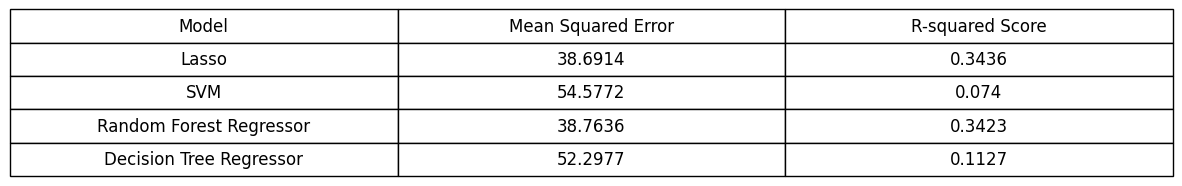

In [16]:
results = []

models = ['Lasso', 'SVM', 'Random Forest Regressor', 'Decision Tree Regressor']
for y_pred, model in zip([y_pred_las, y_pred_svm, y_pred_rfr, y_pred_dtr], models):
    mse = mean_squared_error(y_test, y_pred).__round__(4)
    r2 = r2_score(y_test, y_pred).__round__(4)
    results.append([model, mse, r2])

results_df = pd.DataFrame(results, columns=['Model', 'Mean Squared Error', 'R-squared Score'])

fig, ax = plt.subplots(figsize = (10, 2))
ax.axis('off')
table = ax.table(cellText = results_df.values, colLabels = results_df.columns, cellLoc = 'center', loc = 'center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 2)

plt.show()

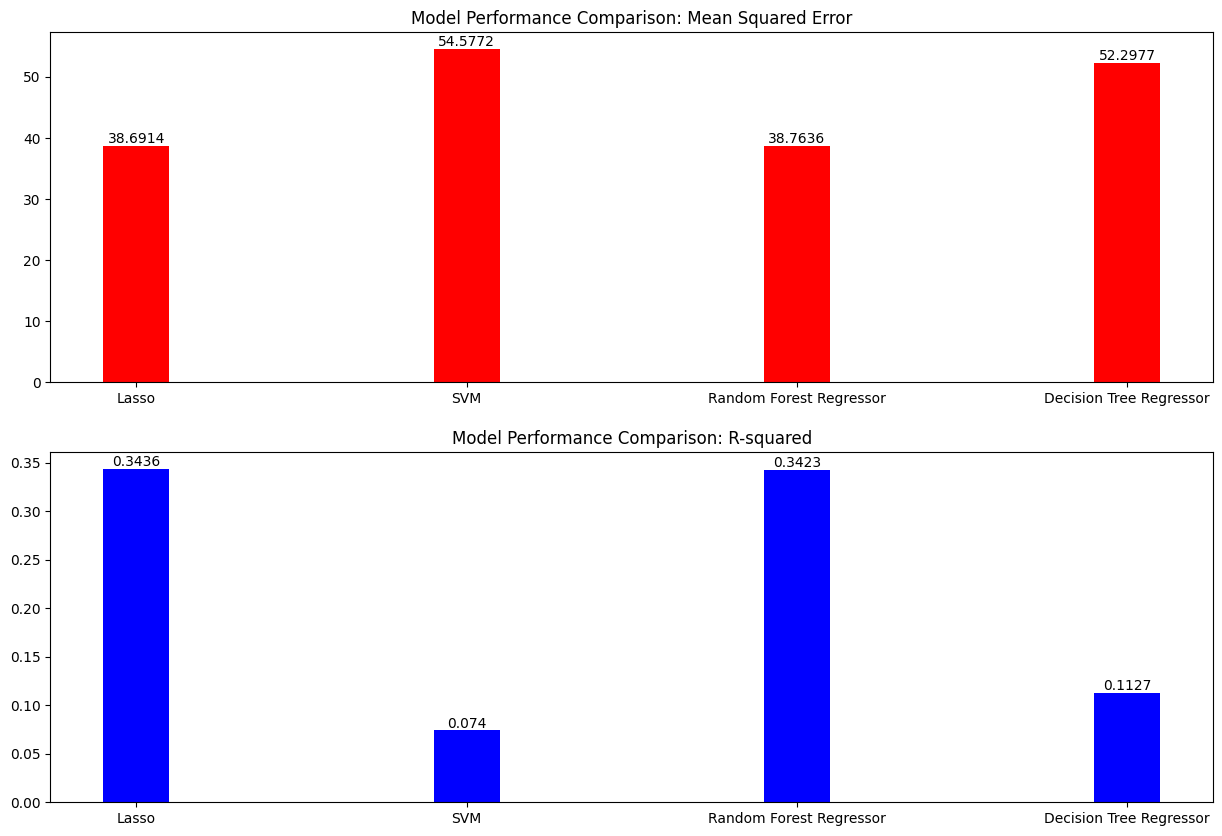

In [17]:
mse = results_df['Mean Squared Error']
r2 = results_df['R-squared Score']

bar_width = 0.2
index = np.arange(len(models))

fig, ax = plt.subplots(nrows = 2, figsize = (15, 10))

mse_figure = ax[0].bar(index, mse, bar_width, color = 'red')
ax[0].bar_label(mse_figure)

ax[0].set_xticks(index, models)
ax[0].set_title('Model Performance Comparison: Mean Squared Error')

r2_figure = ax[1].bar(index, r2, bar_width, color = 'blue')
ax[1].bar_label(r2_figure)

ax[1].set_xticks(index, models)
ax[1].set_title('Model Performance Comparison: R-squared')


plt.show()

### Correlation between actual test and prediction data

In [61]:
tests_df = pd.DataFrame(np.array(tests + [y_test]).T, columns = models + ['Actual Test'])

fig = px.line(tests_df)

fig.update_layout(
    yaxis_title = 'Score',
    title = 'Correlation between testing dataset and prediction data'
)

fig.show()

fig.write_html("./figures/correlation_actual_predict.html")

## Conclusion

**Your conclusion**

Random Forest Regressor is the best model!